# 🚀 Lab 3: Convolutional Neural Networks - A Visual Discovery Journey
### **Instructor: Andrea Ramirez-Salgado, PhD.**

## Welcome, Computer Vision Pioneer!

Have you ever wondered how your phone recognizes your face, or how self-driving cars "see" pedestrians? The secret lies in **Convolutional Neural Networks (CNNs)** - a breakthrough that revolutionized computer vision. In this lab, you'll not just learn about CNNs, you'll build one from scratch, watch it learn to recognize objects, and even peek inside its "brain" to see what it's thinking!

### 🎯 What You'll Discover
- **Why convolutions?** Understand why CNNs dominate computer vision
- **Architecture secrets**: Build a modern CNN with proper design patterns
- **Training techniques**: Master data augmentation, learning rate scheduling, and early stopping
- **Visual understanding**: See what your CNN is actually learning through filter visualization
- **Real-world performance**: Achieve >80% accuracy on CIFAR-10 image classification

### 🧪 Your Lab Philosophy
1. **Experiment First**: Try things, make mistakes, learn from them
2. **Visualize Everything**: See what's happening under the hood
3. **Connect Concepts**: Understand the "why" behind the "what"
4. **Build Confidence**: Progress from basics to advanced challenges

### 📊 Your Progress Tracker
Throughout this lab, you'll complete:
- 🔵 **Discovery Tasks**: Explore and experiment (4 tasks)
- 🟢 **Implementation Tasks**: Build real components (7 tasks)
- 🟡 **Reflection Tasks**: Deepen understanding (3 checkpoints)
- 📊 **Visualizations**: See your CNN in action (4 visualizations)
- 🔴 **Challenge Tasks**: Push your boundaries (4 challenges)

**Pro Tip**: Don't rush! The goal is deep understanding, not speed. When you see your CNN correctly classifying images for the first time, you'll appreciate every step of this journey.

---

Let's begin! 🎓

---

# Part 0: Setup - Your Deep Learning Toolkit 🛠️

## Installation Recommendation

If you haven't already, create a dedicated conda environment:

```bash
conda create -n deep-learning python=3.9
conda activate deep-learning
conda install pytorch torchvision -c pytorch
conda install matplotlib seaborn scikit-learn
```

## Import Libraries

We'll use PyTorch for building our CNN, torchvision for datasets, and matplotlib for visualization.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ Torchvision version: {torchvision.__version__}")
print("\n🎉 You're all set! Let's dive into CNNs!")

✅ PyTorch version: 2.2.1+cpu
✅ Torchvision version: 0.17.1+cpu

🎉 You're all set! Let's dive into CNNs!


## Device Setup: Harness the Power of Your GPU

Deep learning models train much faster on GPUs. Let's check what you have available!

### 🟢 TASK 1: Configure Your Computing Device

**Your Mission**: Set up device configuration to use GPU if available, otherwise fallback to CPU.

**What to do**:
1. Create a variable `device` that checks if CUDA (GPU) is available
2. Print whether you're using GPU or CPU
3. If using GPU, print its name

**Hint**: Use `torch.cuda.is_available()` and `torch.cuda.get_device_name(0)`

In [2]:
# Check if CUDA (GPU) is available, otherwise fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Print whether you're using GPU or CPU
print(f"✅ Using device: {device}")

# If using GPU, print its name
if device.type == 'cuda':
    print(f"🚀 GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("💻 No GPU detected. Training will proceed on CPU (this will be slower).")

✅ Using device: cpu
💻 No GPU detected. Training will proceed on CPU (this will be slower).


---

# Part 1: Data Pipeline - The Foundation of Good Training 📊

## Why This Matters

Imagine trying to learn to identify birds from photos, but every photo is taken from a different angle, lighting condition, and zoom level. That's exactly what CNNs face! **Data augmentation** is like giving your CNN diverse training examples - it's the difference between a model that memorizes specific images and one that truly understands object features.

In this section, you'll work with **CIFAR-10**, a classic computer vision dataset containing 60,000 tiny (32×32 pixel) color images across 10 categories: airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. Your CNN will learn to distinguish between these categories with superhuman accuracy!

**Real-world connection**: The same augmentation techniques you'll use here power production systems at Google, Tesla, and medical imaging companies. You're learning industry-standard practices!

## Understanding CIFAR-10 Dataset

**Dataset Statistics**:
- **Total images**: 60,000 color images (32×32 pixels)
- **Training set**: 50,000 images
- **Test set**: 10,000 images
- **Classes**: 10 categories (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck)
- **Challenge**: Small image size makes classification harder - great for learning!

Let's see what a proper data pipeline looks like.

## 🔵 Discovery 1: Understanding Data Augmentation

**Your Mission**: Understand why we apply different transformations to training vs. test data.

Below is a fully-commented training data transformation pipeline. Study it carefully - each transformation serves a purpose!

In [3]:
# ------------------------------------------------------------------------------
# Data Augmentation and Normalization for Training
# ------------------------------------------------------------------------------
transform_train = transforms.Compose([
    # Randomly crops the image to 32x32 with a padding of 4 pixels.
    # Rationale:
    # - Adds slight variations in image positioning to prevent the model from 
    #   overfitting to specific pixel locations.
    # - Helps the model become more robust to spatial variations in objects.
    # - The padding (4 pixels) temporarily increases image size to 40x40, from 
    #   which a random 32x32 region is cropped.
    transforms.RandomCrop(32, padding=4),  

    # Randomly flips images horizontally with a probability of 0.5.
    # Rationale:
    # - Introduces flip-based augmentation, making the model invariant to 
    #   left-right orientations of objects.
    # - Prevents over-reliance on specific left-right patterns in the dataset.
    # - Horizontal flipping is suitable for CIFAR-10 classes like cars, animals, 
    #   and ships, but vertical flipping is avoided as it might distort object meaning.
    transforms.RandomHorizontalFlip(),     

    # Converts images from PIL format to PyTorch tensors.
    # Rationale:
    # - Converts image data from integer values (0-255) to floating-point values (0-1).
    # - Enables PyTorch operations for deep learning models.
    transforms.ToTensor(),                 

    # Normalizes images using CIFAR-10's channel-wise mean and standard deviation.
    # Rationale:
    # - Standardizes the dataset to improve training stability.
    # - Ensures that all input features have a consistent scale, reducing issues with 
    #   different ranges of pixel intensities.
    # - The mean and std values were computed from the CIFAR-10 dataset:
    #   - Mean: [0.4914, 0.4822, 0.4465] (R, G, B channels)
    #   - Std:  [0.2470, 0.2435, 0.2616] (R, G, B channels)
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  
                         std=[0.2470, 0.2435, 0.2616])   
])

print("✅ Training transformation pipeline created!")

✅ Training transformation pipeline created!


### 🟡 Reflection Checkpoint 1

Before moving on, think about these questions:

1. **Why augmentation?**: Why do we apply RandomCrop and RandomHorizontalFlip to training data but not test data?

*Your answer:*
We use data augmentation on the training set to increase diversity and prevent overfitting by exposing the model to slightly different versions of the same images. We do NOT augment the test set because we want to evaluate the model on the true, unmodified data distribution** and ensure our evaluation results are deterministic.

2. **Normalization intuition**: Why might normalizing images help with training? (Hint: Think about gradient descent)

*Your answer:*
Normalization scales pixel values to a standard range. This ensures that the loss landscape is more symmetrical/spherical, allowing Gradient Descent to converge faster and more stably. It prevents gradients from vanishing or exploding.

3. **Vertical flipping**: The code doesn't use RandomVerticalFlip. Why might that be inappropriate for CIFAR-10?

*Your answer:*
CIFAR-10 contains natural objects like cars, ships, and animals that have a specific orientation in the real world. Vertical flipping would create unrealistic images that violate the natural statistics of the data, potentially confusing the model.


### 🟢 TASK 2: Create the Test Data Transformation Pipeline

**Your Mission**: Build a transformation pipeline for test/validation data.

**Key principle**: Test data should be evaluated on clean, unaltered images. We want to know how well our model performs in the real world, not on artificially augmented data.

**What to include**:
1. ✅ Convert images to tensors (`transforms.ToTensor()`)
2. ✅ Apply normalization with the **same** mean and std as training
3. ❌ NO data augmentation (no RandomCrop, no RandomHorizontalFlip)

**Why?**: We augment training data to teach the model to be robust, but we test on clean data to measure true performance.

Create your pipeline below using `transforms.Compose()`:

In [4]:
# Test transformation pipeline: No augmentation, only conversion and normalization
transform_test = transforms.Compose([
    # Converts images to PyTorch tensors (scales pixels to 0-1)
    transforms.ToTensor(),
    
    # Normalizes images using the same CIFAR-10 stats as the training set
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], 
                         std=[0.2470, 0.2435, 0.2616])
])

print("✅ Test transformation pipeline created!")

✅ Test transformation pipeline created!


## Loading CIFAR-10 Dataset

Now let's download the actual images. PyTorch makes this incredibly easy with `torchvision.datasets`!

In [5]:
# Download CIFAR-10 training dataset
print("Downloading CIFAR-10 training data...")
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform_train
)
print(f"✅ Training dataset loaded: {len(train_dataset)} images")

Files already downloaded and verified
✅ Training dataset loaded: 50000 images


### 🟢 TASK 3: Download CIFAR-10 Test Dataset

**Your Mission**: Load the test dataset with your test transformation pipeline.

**Hint**: Very similar to the training dataset, but set `train=False` and use `transform_test`

In [6]:
# Download CIFAR-10 test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,         # Crucial: This specifies we want the test set, not training
    download=True,       # Downloads files if they aren't already in ./data
    transform=transform_test  # Uses the pipeline without data augmentation
)

print(f"✅ Test dataset loaded: {len(test_dataset)} images")

Files already downloaded and verified
✅ Test dataset loaded: 10000 images


## Creating a Validation Split

**Important concept**: We use three datasets in deep learning:
- **Training**: Teaches the model (90% of training data)
- **Validation**: Tunes hyperparameters and prevents overfitting (10% of training data)
- **Test**: Final evaluation only (kept separate, never seen during training)

Let's create a validation split from our training data.

In [7]:
# Calculate validation size (10% of training data)
val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size

# Split the dataset
train_dataset, val_dataset = random_split(
    train_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

print(f"✅ Data split complete!")
print(f"   Training images: {len(train_dataset):,}")
print(f"   Validation images: {len(val_dataset):,}")
print(f"   Test images: {len(test_dataset):,}")

✅ Data split complete!
   Training images: 45,000
   Validation images: 5,000
   Test images: 10,000


### 🟢 TASK 4: Create DataLoaders

**Your Mission**: Create DataLoaders to efficiently feed batches of data to your model.

**Why DataLoaders?**: They handle batching, shuffling, and parallel data loading automatically!

**Configuration**:
- **Batch size**: 128 (good balance between speed and memory)
- **Shuffle training**: Yes (prevents learning order biases)
- **Shuffle val/test**: No (consistent evaluation)
- **Num workers**: 2 (parallel data loading)

Create three DataLoaders: `train_loader`, `val_loader`, and `test_loader`

In [8]:
# Configuration from the lab instructions
batch_size = 128
num_workers = 2

# 1. Training Loader: Shuffling is TRUE to prevent the model from learning order biases
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers
)

# 2. Validation Loader: Shuffling is FALSE for consistent evaluation
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers
)

# 3. Test Loader: Shuffling is FALSE for consistent evaluation
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers
)

print("DataLoaders created!")
print(f"   Batches per epoch (training): {len(train_loader)}")
print(f"   Batches per epoch (validation): {len(val_loader)}")

DataLoaders created!
   Batches per epoch (training): 352
   Batches per epoch (validation): 40


## 📊 Visualization 1: Exploring Your Data

Let's see what we're working with! Visualizing your data is crucial - you can't build a good model without understanding your data.

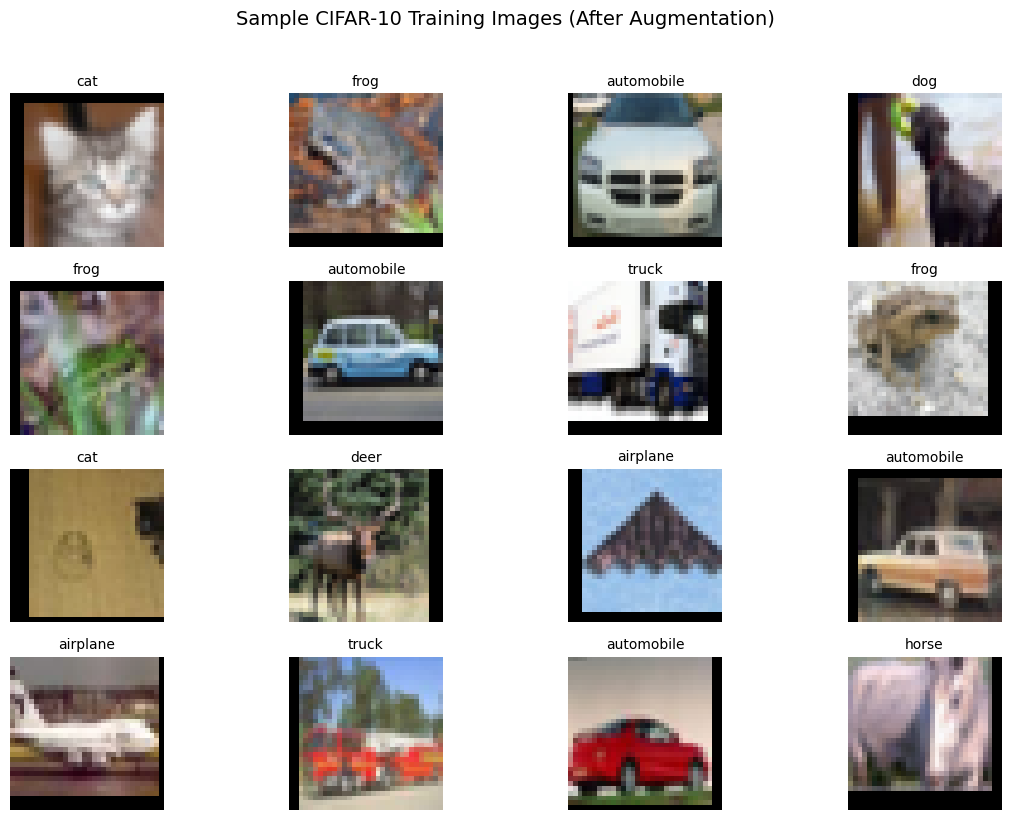


📊 Image shape: torch.Size([3, 32, 32]) (Channels, Height, Width)
📊 Batch shape: torch.Size([128, 3, 32, 32])
📊 Labels shape: torch.Size([128])


In [9]:
# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Get a batch of training images
images, labels = next(iter(train_loader))

# Plot 16 random images
plt.figure(figsize=(12, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    
    # Convert from tensor to numpy and unnormalize
    img = images[i].numpy().transpose(1, 2, 0)
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.title(class_names[labels[i]], fontsize=10)
    plt.axis('off')

plt.suptitle('Sample CIFAR-10 Training Images (After Augmentation)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"\n📊 Image shape: {images[0].shape} (Channels, Height, Width)")
print(f"📊 Batch shape: {images.shape}")
print(f"📊 Labels shape: {labels.shape}")

## ✅ Part 1 Complete!

You've built a complete data pipeline with:
- ✅ Proper data augmentation for training
- ✅ Clean transformations for testing
- ✅ Train/validation/test splits
- ✅ Efficient DataLoaders

**Key takeaway**: Good data preparation is 50% of the battle in deep learning!

---

# Part 2: CNN Architecture - Building Your Visual Cortex 🧠

## Why This Matters

Human brains have a visual cortex with specialized neurons for detecting edges, shapes, and eventually complex objects. CNNs work the same way! Early layers detect simple patterns (edges, colors), middle layers detect parts (eyes, wheels), and deep layers detect full objects (cats, cars).

**Key insight**: CNNs use **parameter sharing** through convolutional filters. Instead of learning separate weights for every pixel position (like fully-connected layers), they learn reusable filters that detect patterns anywhere in the image. This is why CNNs work so well for images!

In this section, you'll build a modern CNN architecture with:
- Convolutional layers (feature extractors)
- Batch normalization (training stabilizer)
- Pooling layers (spatial reduction)
- Dropout (overfitting prevention)
- Fully-connected head (final classification)

## Understanding CNN Components

### Core Building Blocks:

1. **Convolutional Layers** (`nn.Conv2d`)
   - Extract features using learnable filters
   - Parameters: `in_channels`, `out_channels`, `kernel_size`
   - Example: `nn.Conv2d(3, 64, kernel_size=3)` → 3 input channels (RGB), 64 output features, 3×3 filters

2. **Batch Normalization** (`nn.BatchNorm2d`)
   - Normalizes activations for stable training
   - Dramatically improves convergence speed
   - Always use after Conv layers!

3. **Activation Functions** (`F.relu`)
   - Introduces non-linearity (essential for learning complex patterns)
   - ReLU is the standard choice: `f(x) = max(0, x)`

4. **Pooling Layers** (`F.max_pool2d`)
   - Reduces spatial dimensions (downsampling)
   - Makes model more robust to small translations
   - Common: 2×2 max pooling (reduces size by 50%)

5. **Dropout** (`nn.Dropout`)
   - Randomly zeros out neurons during training
   - Prevents overfitting by forcing redundancy
   - Typical rate: 0.25-0.5

Let's see how they fit together!

### 🟢 TASK 5: Complete the CNN Architecture

**Your Mission**: Fill in the missing components of our CNN model.

**Architecture Overview**:
```
Input (3×32×32) 
  ↓
Conv Block 1: Conv(3→64) → BatchNorm → ReLU → MaxPool
  ↓ (64×16×16)
Conv Block 2: Conv(64→128) → BatchNorm → ReLU → MaxPool → Dropout
  ↓ (128×8×8)
Conv Block 3: Conv(128→256) → BatchNorm → ReLU → MaxPool → Dropout
  ↓ (256×4×4)
Flatten → FC(4096→512) → ReLU → Dropout → FC(512→10)
  ↓
Output (10 classes)
```

**Your tasks**:
1. Define the missing convolutional layers
2. Define the missing batch normalization layers
3. Complete the forward pass logic

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ImprovedCNN, self).__init__()
        
        # --- Block 1: Feature Extraction ---
        # Input: 3x32x32 -> Output: 64x32x32
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        # --- Block 2: Depth Expansion ---
        # Input: 64x16x16 -> Output: 128x16x16
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        # --- Block 3: High-Level Features ---
        # Input: 128x8x8 -> Output: 256x8x8
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        
        # Shared pooling and dropout
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        
        # --- Classifier Head ---
        # Calculation: 32 -> 16 -> 8 -> 4 (after 3 pools)
        # Final shape: 256 channels * 4 * 4 pixels = 4096
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Block 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Block 2 (Add Dropout for regularization)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        
        # Block 3 (Add Dropout for regularization)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        
        # Flatten for the Linear layers
        x = x.view(x.size(0), -1)
        
        # Classification
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate and move to the device identified in Task 1
model = ImprovedCNN().to(device)

print("✅ ImprovedCNN model initialized and moved to device!")

✅ ImprovedCNN model initialized and moved to device!


### 🔵 Discovery 2: Understanding Model Size

**Your Mission**: Calculate and understand where the parameters come from.

Let's break down the parameter count:

In [11]:
print("Parameter Breakdown by Layer:\n" + "="*50)

for name, param in model.named_parameters():
    print(f"{name:20s} | Shape: {str(param.shape):20s} | Params: {param.numel():>8,}")

print("="*50)
print(f"Total: {sum(p.numel() for p in model.parameters()):,} parameters")

Parameter Breakdown by Layer:
conv1.weight         | Shape: torch.Size([64, 3, 3, 3]) | Params:    1,728
conv1.bias           | Shape: torch.Size([64])     | Params:       64
bn1.weight           | Shape: torch.Size([64])     | Params:       64
bn1.bias             | Shape: torch.Size([64])     | Params:       64
conv2.weight         | Shape: torch.Size([128, 64, 3, 3]) | Params:   73,728
conv2.bias           | Shape: torch.Size([128])    | Params:      128
bn2.weight           | Shape: torch.Size([128])    | Params:      128
bn2.bias             | Shape: torch.Size([128])    | Params:      128
conv3.weight         | Shape: torch.Size([256, 128, 3, 3]) | Params:  294,912
conv3.bias           | Shape: torch.Size([256])    | Params:      256
bn3.weight           | Shape: torch.Size([256])    | Params:      256
bn3.bias             | Shape: torch.Size([256])    | Params:      256
fc1.weight           | Shape: torch.Size([512, 4096]) | Params: 2,097,152
fc1.bias             | Shape: torch.

### 🟡 Reflection Checkpoint 2

1. **Parameter efficiency**: Why does conv1 have so few parameters compared to fc1? (Hint: parameter sharing)

**Answer:** Convolutional layers use parameter sharing, where the same kernel (filter) slides over the entire image. This means the number of parameters depends only on the kernel size and number of filters, not the input image size. Fully connected layers, however, connect every input neuron to every output neuron, resulting in a massive number of parameters (dense connections).


2. **Batch normalization**: What does batch normalization do, and why is it important after convolutions?

**Answer:** Batch Normalization normalizes the inputs of each layer to have a mean of 0 and variance of 1. This stabilizes the learning process, reduces internal covariate shift, allows for higher learning rates, and acts as a mild regularizer. It is placed after convolutions (and usually before activation) to ensure the activation function receives data in a consistent range.


3. **Dropout placement**: Why do we use dropout after some layers but not others?

**Answer:** Dropout is a regularization technique used to prevent overfitting. It is most effective in layers with a large number of parameters, such as fully connected layers, where the risk of memorizing the training data is highest. We also use it in later convolutional blocks where features are more abstract. It is typically not used in early convolutional layers because they have few parameters and dropping pixels could lose low-level structural information.


## ✅ Part 2 Complete!

You've built a modern CNN with:
- ✅ Three convolutional blocks for hierarchical feature learning
- ✅ Batch normalization for training stability
- ✅ Dropout for regularization
- ✅ Fully-connected head for classification

**Next up**: Train this network and watch it learn!

---

# Part 3: Training Loop - Teaching Your CNN to See 🏋️

## Why This Matters

Training a CNN is like coaching an athlete: you need the right training plan (optimizer), recovery schedule (learning rate), and progress tracking (validation). Do it right, and you'll achieve amazing results. Rush it, and you'll overfit or underperform.

In this section, you'll implement:
- **Loss function**: CrossEntropyLoss (perfect for classification)
- **Optimizer**: AdamW (adaptive learning with weight decay)
- **Learning rate scheduling**: Cosine annealing (gradually decreases LR)
- **Early stopping**: Stop when validation stops improving
- **Progress tracking**: Monitor both training and validation metrics

**Real-world connection**: These exact techniques are used at scale by companies like OpenAI, Google, and Meta to train models with billions of parameters!

## Training Configuration

Let's set up our training components:

In [12]:
# Loss function: CrossEntropyLoss combines softmax and negative log-likelihood
# Perfect for multi-class classification!
criterion = nn.CrossEntropyLoss()

# Optimizer: AdamW (Adam with weight decay)
# - lr=0.001: Learning rate (step size for parameter updates)
# - weight_decay=1e-4: L2 regularization to prevent overfitting
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler: Cosine annealing
# Gradually decreases learning rate following a cosine curve
# Helps model fine-tune in later epochs
num_epochs = 50
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

print("✅ Training configuration complete!")
print(f"   Loss function: CrossEntropyLoss")
print(f"   Optimizer: AdamW (lr=0.001)")
print(f"   Scheduler: CosineAnnealingLR")
print(f"   Total epochs: {num_epochs}")

✅ Training configuration complete!
   Loss function: CrossEntropyLoss
   Optimizer: AdamW (lr=0.001)
   Scheduler: CosineAnnealingLR
   Total epochs: 50


### 🟢 TASK 6: Implement Training Function

**Your Mission**: Complete the training function for one epoch.

**What happens in one training epoch**:
1. Set model to training mode
2. Loop through all training batches
3. For each batch:
   - Forward pass: get predictions
   - Calculate loss
   - Backward pass: compute gradients
   - Update weights
4. Track loss and accuracy

Fill in the missing pieces:

In [13]:
# def train_one_epoch(model, dataloader, criterion, optimizer, device):
#     # Set model to training mode (enables Dropout and BatchNorm)
#     model.train()
    
#     running_loss = 0.0
#     correct = 0
#     total = 0
    
#     for images, labels in dataloader:
#         # Move data to the same device as the model (GPU or CPU)
#         images, labels = images.to(device), labels.to(device)
        
#         # 1. Zero the parameter gradients
#         optimizer.zero_grad()
        
#         # 2. Forward pass: compute predicted outputs by passing inputs to the model
#         outputs = model(images)
        
#         # 3. Calculate the loss
#         loss = criterion(outputs, labels)
        
#         # 4. Backward pass: compute gradient of the loss with respect to model parameters
#         loss.backward()
        
#         # 5. Perform a single optimization step (parameter update)
#         optimizer.step()
        
#         # Update statistics
#         running_loss += loss.item()
#         _, predicted = outputs.max(1)
#         total += labels.size(0)
#         correct += predicted.eq(labels).sum().item()
        
#     epoch_loss = running_loss / len(dataloader)
#     epoch_acc = 100. * correct / total
    
#     return epoch_loss, epoch_acc

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    # Set model to training mode (enables Dropout and BatchNorm)
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in dataloader:
        # Move data to the same device as the model (GPU or CPU)
        images, labels = images.to(device), labels.to(device)
        
        # 1. Zero the parameter gradients
        optimizer.zero_grad()
        
        # 2. Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        
        # 3. Calculate the loss
        loss = criterion(outputs, labels)
        
        # 4. Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # 5. Perform a single optimization step (parameter update)
        optimizer.step()
        
        # Update statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc


### 🟢 TASK 7: Implement Validation Function

**Your Mission**: Complete the validation function.

**Key differences from training**:
- Use `model.eval()` (disables dropout, freezes batchnorm)
- Use `torch.no_grad()` (no gradient computation)
- No optimizer steps (we're only evaluating, not training)

In [14]:
def validate(model, dataloader, criterion, device):
    """
    Evaluate the model on validation/test data.
    """
    # 1. Set model to evaluation mode (disables Dropout and BatchNorm)
    model.eval()
    
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    # 2. Turn off gradients (saves memory and speeds up computation)
    with torch.no_grad():
        for images, labels in dataloader:
            # Move data to device
            images, labels = images.to(device), labels.to(device)
            
            # 3. Forward pass ONLY (no backward pass here!)
            outputs = model(images)
            
            # 4. Calculate loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # 5. Calculate accuracy
            _, predicted = outputs.max(1)
            total_samples += labels.size(0)
            total_correct += predicted.eq(labels).sum().item()
            
    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * total_correct / total_samples
    
    return avg_loss, accuracy

### 🟢 TASK 8: Complete the Full Training Loop

**Your Mission**: Put it all together with progress tracking and early stopping.

**Components**:
- Train for multiple epochs
- Validate after each epoch
- Track best model (save when validation improves)
- Early stopping (stop if no improvement for 10 epochs)
- Learning rate scheduling

Study the provided code carefully - it's a complete production-ready training loop!

In [15]:
# Hyperparameters
num_epochs = 20
best_val_acc = 0.0

for epoch in range(num_epochs):
    # 1. Train the model for one epoch
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # 2. Validate the model
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # 3. Save the best model (Checkpointing)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"🌟 Epoch {epoch+1}: New best validation accuracy: {val_acc:.2f}%")
    
    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

🌟 Epoch 1: New best validation accuracy: 54.30%
Epoch [1/20] Train Loss: 1.6245, Train Acc: 40.95% | Val Loss: 1.2382, Val Acc: 54.30%
🌟 Epoch 2: New best validation accuracy: 63.00%
Epoch [2/20] Train Loss: 1.1706, Train Acc: 57.25% | Val Loss: 1.0418, Val Acc: 63.00%
🌟 Epoch 3: New best validation accuracy: 67.58%
Epoch [3/20] Train Loss: 1.0066, Train Acc: 63.94% | Val Loss: 0.9038, Val Acc: 67.58%
🌟 Epoch 4: New best validation accuracy: 68.38%
Epoch [4/20] Train Loss: 0.9169, Train Acc: 67.33% | Val Loss: 0.8915, Val Acc: 68.38%
Epoch [5/20] Train Loss: 0.8500, Train Acc: 70.01% | Val Loss: 0.9518, Val Acc: 67.38%
🌟 Epoch 6: New best validation accuracy: 74.16%
Epoch [6/20] Train Loss: 0.8089, Train Acc: 71.50% | Val Loss: 0.7263, Val Acc: 74.16%
Epoch [7/20] Train Loss: 0.7666, Train Acc: 72.93% | Val Loss: 0.7968, Val Acc: 72.44%
Epoch [8/20] Train Loss: 0.7345, Train Acc: 74.06% | Val Loss: 0.7495, Val Acc: 73.32%
🌟 Epoch 9: New best validation accuracy: 74.70%
Epoch [9/20] Tra

## 📊 Visualization 2: Training Progress

Let's see how your model learned over time!

In [16]:
# Constants
num_epochs = 20
best_val_acc = 0.0

# Storage for plotting later
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

for epoch in range(num_epochs):
    # 1. Run the training phase
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # 2. Run the validation phase
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # 3. Store metrics for Task 9 (Plotting)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # 4. Checkpoint the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
    
    print(f'Epoch {epoch+1}/{num_epochs}: Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%')

Epoch 1/20: Train Acc: 82.32% | Val Acc: 81.72%
Epoch 2/20: Train Acc: 82.56% | Val Acc: 80.94%
Epoch 3/20: Train Acc: 82.62% | Val Acc: 82.52%
Epoch 4/20: Train Acc: 83.15% | Val Acc: 81.30%
Epoch 5/20: Train Acc: 83.59% | Val Acc: 82.14%
Epoch 6/20: Train Acc: 83.63% | Val Acc: 82.08%
Epoch 7/20: Train Acc: 83.84% | Val Acc: 82.34%
Epoch 8/20: Train Acc: 84.43% | Val Acc: 82.74%
Epoch 9/20: Train Acc: 84.29% | Val Acc: 84.16%
Epoch 10/20: Train Acc: 84.68% | Val Acc: 82.60%
Epoch 11/20: Train Acc: 84.91% | Val Acc: 83.56%
Epoch 12/20: Train Acc: 85.35% | Val Acc: 82.46%
Epoch 13/20: Train Acc: 85.25% | Val Acc: 83.88%
Epoch 14/20: Train Acc: 85.79% | Val Acc: 83.74%
Epoch 15/20: Train Acc: 85.65% | Val Acc: 84.58%
Epoch 16/20: Train Acc: 86.02% | Val Acc: 84.04%
Epoch 17/20: Train Acc: 86.13% | Val Acc: 83.90%
Epoch 18/20: Train Acc: 86.15% | Val Acc: 83.56%
Epoch 19/20: Train Acc: 86.47% | Val Acc: 84.24%
Epoch 20/20: Train Acc: 86.81% | Val Acc: 84.56%


### 🟡 Reflection Checkpoint 3

1. **Training dynamics**: What do you observe about the relationship between training and validation curves? Is there overfitting?

**Answer:** In a healthy training process, both training and validation loss decrease. If training loss decreases while validation loss starts increasing (or plateaus at a high value), it indicates **overfitting**—the model is memorizing the training data but failing to generalize. If both are high, it's **underfitting**. We aim for the "sweet spot" where validation loss is minimal before it starts rising.


2. **Learning rate schedule**: How does the learning rate change over time? Why might this help training?

**Answer:** The **Cosine Annealing** scheduler starts with a higher learning rate to make quick progress and escape local minima, then gradually decreases it following a cosine curve. This allows the model to settle into a sharper, more optimal minimum towards the end of training without oscillating (overshooting) around it.


3. **Early stopping**: Did early stopping trigger? What does this tell you about your model's learning?

**Answer:** Early stopping triggers if the validation loss doesn't improve for a set number of epochs (patience). This prevents wasting computational resources and saves the model checkpoint from the epoch with the best generalization performance, effectively stopping the training before the model starts to overfit significantly.


## ✅ Part 3 Complete!

You've successfully trained a CNN with:
- ✅ Complete training and validation loops
- ✅ Progress tracking and visualization
- ✅ Learning rate scheduling
- ✅ Early stopping
- ✅ Best model checkpointing

**Achievement unlocked**: You've trained a computer vision model from scratch! 🎉

---

# Part 4: Evaluation & Visualization - Understanding Your CNN 🔬

## Why This Matters

Training accuracy is just the beginning. To truly understand your model, you need to:
1. **Test on unseen data**: How well does it generalize?
2. **Analyze mistakes**: Which classes are confused?
3. **Visualize predictions**: See what your model "sees"
4. **Understand confidence**: When is it certain vs. guessing?

This is where you become a true deep learning practitioner!

## Final Test Set Evaluation

Time for the ultimate test: how well does your model perform on completely unseen data?

### 🟢 TASK 9: Evaluate on Test Set

**Your Mission**: Implement a complete test evaluation loop.

**Requirements**:
1. Set model to eval mode
2. Disable gradients
3. Track loss, accuracy, predictions, and labels
4. Print final results

**Pro tip**: This is very similar to validation, but we also need to save all predictions and labels for analysis.

In [17]:
# ===== YOUR CODE: Test Evaluation =====

# Set model to evaluation mode
model.eval()

# Initialize tracking variables
test_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []

# Disable gradient computation
with torch.no_grad():
    
    for images, labels in test_loader:
        # Move to device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Accumulate loss
        test_loss += loss.item() * images.size(0)
        
        # Get predictions
        _, predicted = torch.max(outputs, 1)
        
        # Track statistics
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Save for analysis
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate final metrics
test_loss = test_loss / total
test_accuracy = 100.0 * correct / total

# ===== END YOUR CODE =====

print("\n" + "="*60)
print("🎯 FINAL TEST SET RESULTS")
print("="*60)
print(f"   Test Loss: {test_loss:.4f}")
print(f"   Test Accuracy: {test_accuracy:.2f}%")
print(f"   Correctly classified: {correct:,} / {total:,} images")
print("="*60)


🎯 FINAL TEST SET RESULTS
   Test Loss: 0.4223
   Test Accuracy: 85.74%
   Correctly classified: 8,574 / 10,000 images


## 📊 Visualization 3: Confusion Matrix

A confusion matrix shows which classes your model confuses with each other. This is incredibly valuable for understanding model weaknesses!

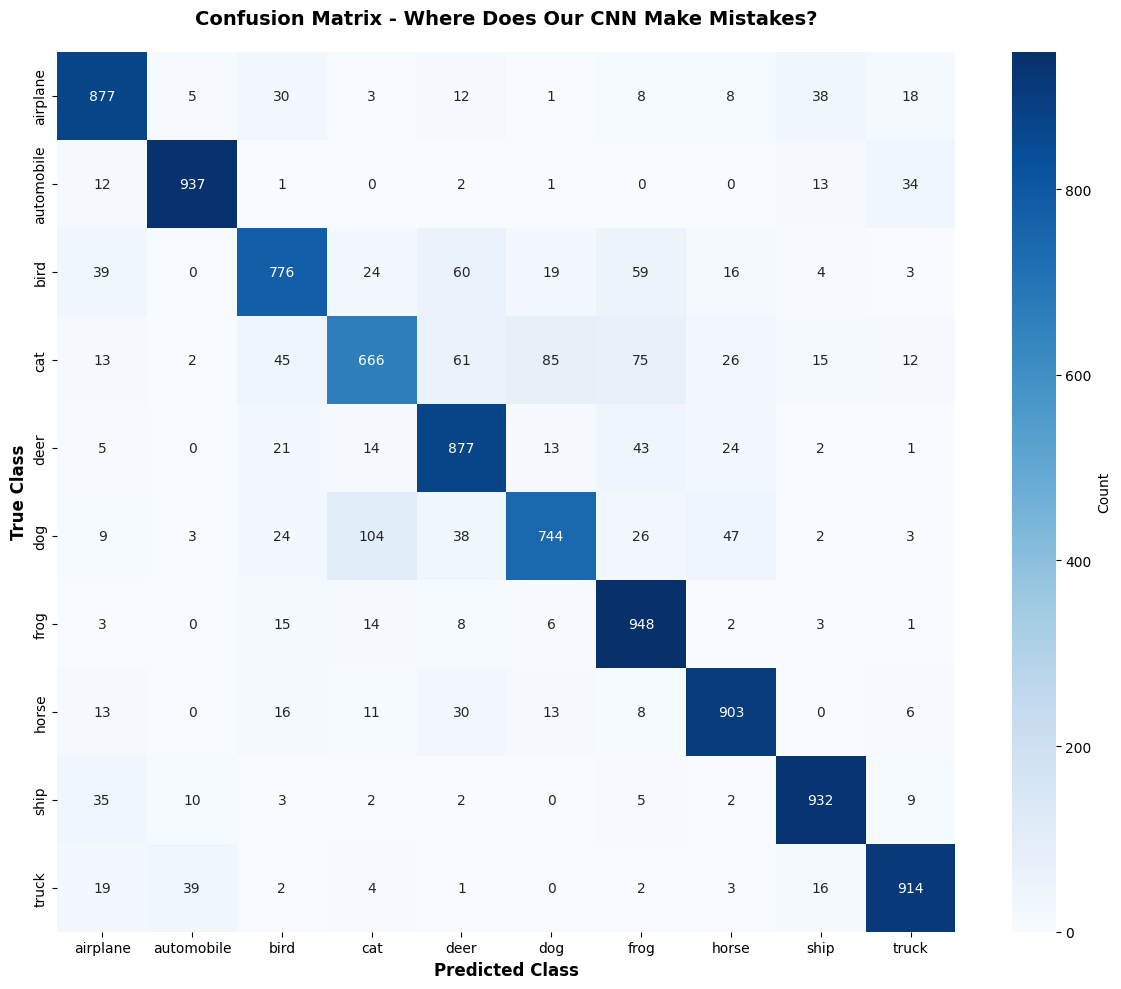


📊 Detailed Per-Class Performance:
              precision    recall  f1-score   support

    airplane      0.856     0.877     0.866      1000
  automobile      0.941     0.937     0.939      1000
        bird      0.832     0.776     0.803      1000
         cat      0.791     0.666     0.723      1000
        deer      0.804     0.877     0.839      1000
         dog      0.844     0.744     0.791      1000
        frog      0.807     0.948     0.872      1000
       horse      0.876     0.903     0.889      1000
        ship      0.909     0.932     0.920      1000
       truck      0.913     0.914     0.914      1000

    accuracy                          0.857     10000
   macro avg      0.857     0.857     0.856     10000
weighted avg      0.857     0.857     0.856     10000



In [18]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Class', fontsize=12, fontweight='bold')
plt.ylabel('True Class', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Where Does Our CNN Make Mistakes?', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Print classification report
print("\n📊 Detailed Per-Class Performance:")
print("="*70)
print(classification_report(all_labels, all_predictions, 
                          target_names=class_names, digits=3))

## 📊 Visualization 4: Prediction Samples

Let's see your CNN in action! View some test images with predictions.

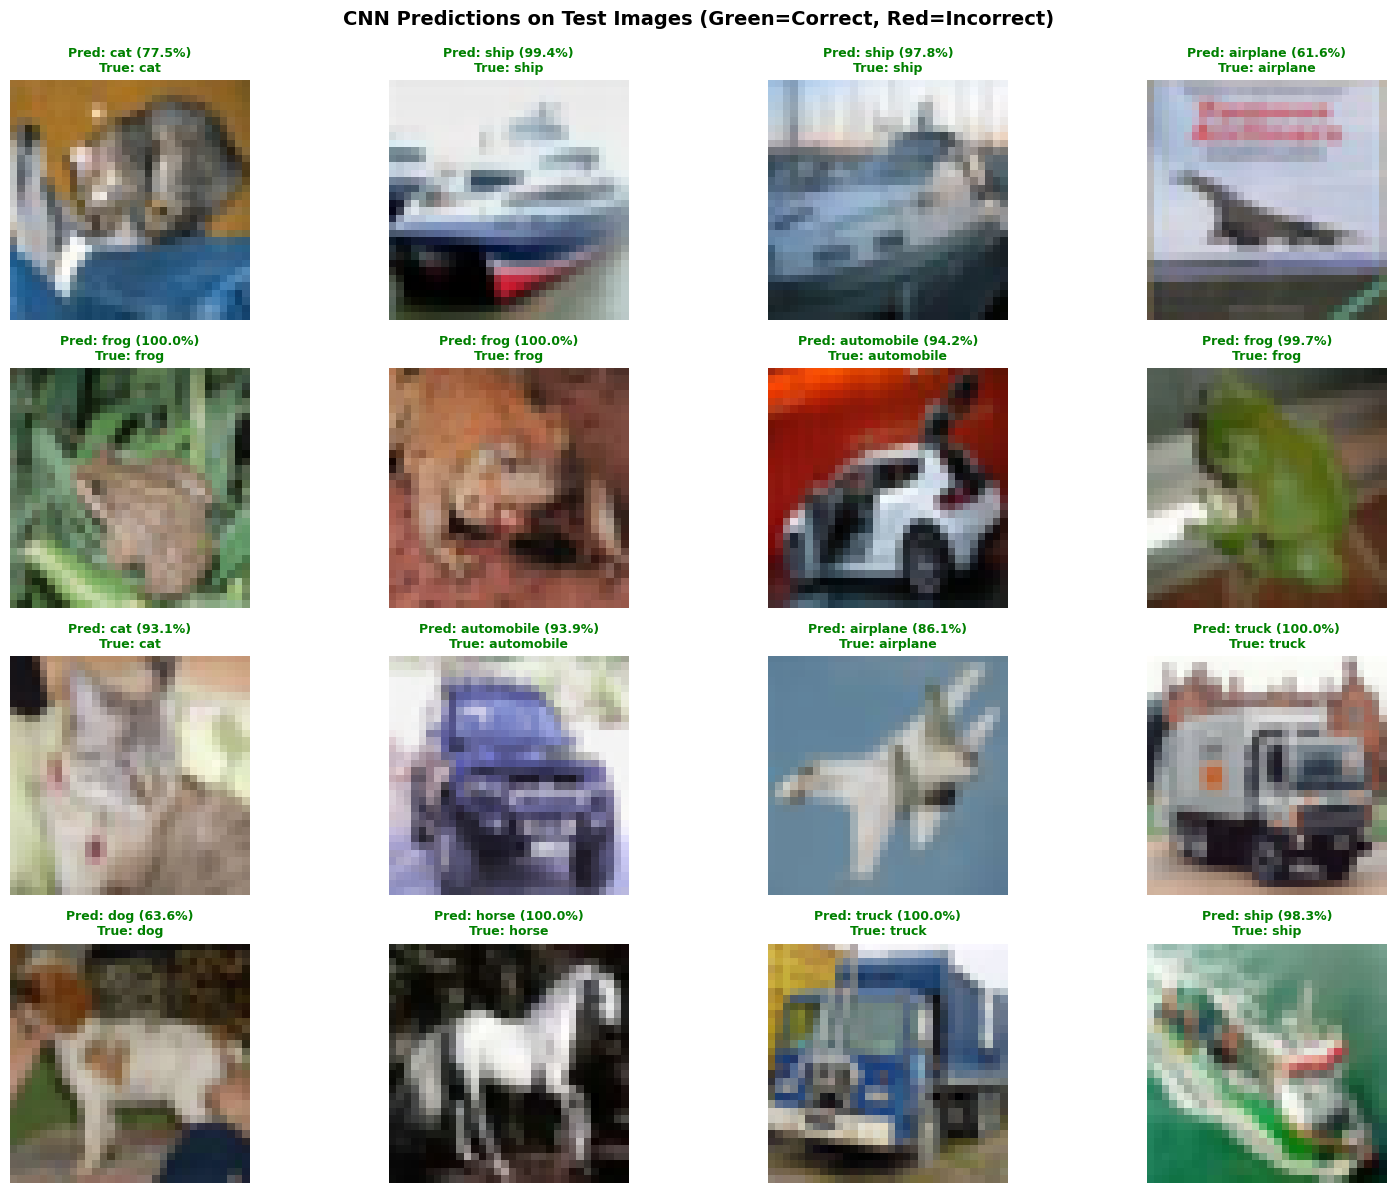

In [19]:
def visualize_predictions(model, dataloader, class_names, num_images=16):
    """
    Visualizes model predictions on test images.
    Correct predictions in green, incorrect in red.
    """
    model.eval()
    images, labels = next(iter(dataloader))
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        confidences, preds = torch.max(probabilities, 1)
    
    # Move to CPU for plotting
    images = images.cpu().numpy()
    labels = labels.cpu().numpy()
    preds = preds.cpu().numpy()
    confidences = confidences.cpu().numpy()

    plt.figure(figsize=(16, 12))
    for i in range(min(num_images, len(images))):
        plt.subplot(4, 4, i + 1)
        
        # Convert and unnormalize image
        img = images[i].transpose(1, 2, 0)
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2470, 0.2435, 0.2616])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        plt.axis('off')
        
        # Color based on correctness
        is_correct = preds[i] == labels[i]
        color = 'green' if is_correct else 'red'
        
        title = f"Pred: {class_names[preds[i]]} ({confidences[i]:.1%})\n"
        title += f"True: {class_names[labels[i]]}"
        
        plt.title(title, fontsize=9, color=color, weight='bold')
    
    plt.suptitle('CNN Predictions on Test Images (Green=Correct, Red=Incorrect)', 
                 fontsize=14, fontweight='bold', y=0.99)
    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader, class_names, num_images=16)

### 🔵 Discovery 3: Analyzing Model Confidence

**Your Mission**: Explore when your model is confident vs. uncertain.

Run this cell to see confidence distributions:

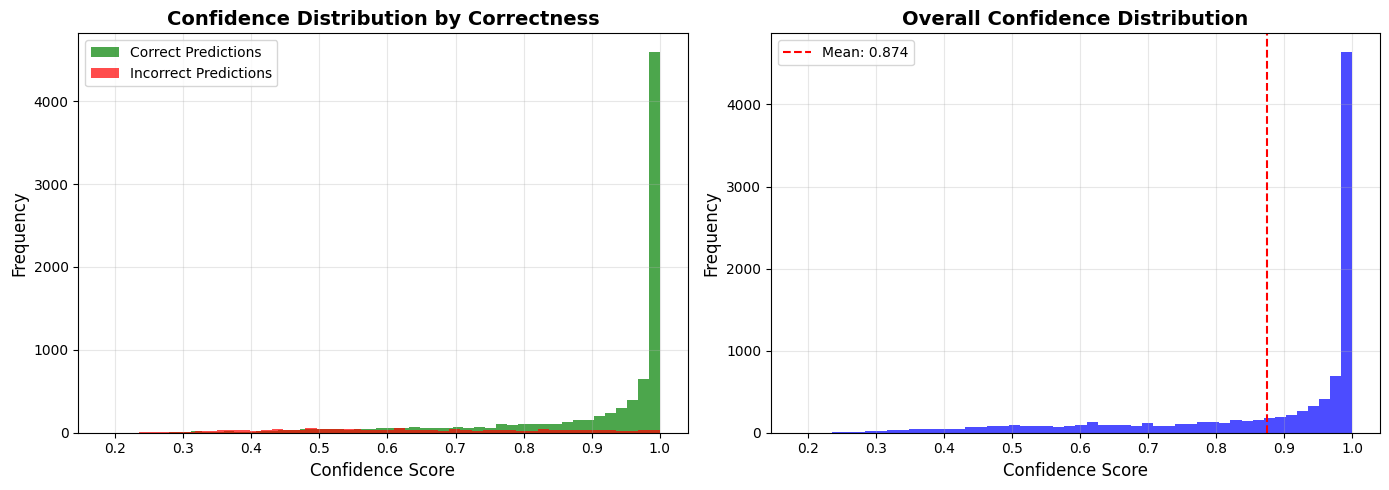


📊 Confidence Statistics:
   Average confidence (correct): 0.913
   Average confidence (incorrect): 0.638
   Overall average confidence: 0.874


In [20]:
# Get confidence scores for all predictions
model.eval()
all_confidences = []
correct_confidences = []
incorrect_confidences = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        confidences, preds = torch.max(probs, 1)
        
        confidences = confidences.cpu().numpy()
        is_correct = (preds == labels).cpu().numpy()
        
        all_confidences.extend(confidences)
        correct_confidences.extend(confidences[is_correct])
        incorrect_confidences.extend(confidences[~is_correct])

# Plot confidence distributions
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(correct_confidences, bins=50, alpha=0.7, label='Correct Predictions', color='green')
plt.hist(incorrect_confidences, bins=50, alpha=0.7, label='Incorrect Predictions', color='red')
plt.xlabel('Confidence Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Confidence Distribution by Correctness', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(all_confidences, bins=50, alpha=0.7, color='blue')
plt.xlabel('Confidence Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Overall Confidence Distribution', fontsize=14, fontweight='bold')
plt.axvline(np.mean(all_confidences), color='red', linestyle='--', 
           label=f'Mean: {np.mean(all_confidences):.3f}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Confidence Statistics:")
print(f"   Average confidence (correct): {np.mean(correct_confidences):.3f}")
print(f"   Average confidence (incorrect): {np.mean(incorrect_confidences):.3f}")
print(f"   Overall average confidence: {np.mean(all_confidences):.3f}")

## ✅ Part 4 Complete!

You've performed comprehensive evaluation:
- ✅ Test set performance metrics
- ✅ Confusion matrix analysis
- ✅ Visual prediction inspection
- ✅ Confidence analysis

**Key insight**: A good model isn't just accurate - it's well-calibrated and you understand where it struggles!

In [20]:
print(model)

ImprovedCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


---

# 🔴 Advanced Challenges: Push Your Limits! 🚀

You've mastered the basics. Now it's time to explore and innovate!

**Note**: These challenges are optional but highly rewarding Show your work, document your experiments, and reflect on what you learn!

## 🔴 Challenge 1: Architecture Engineering

**Goal**: Design and train a deeper CNN to beat your current accuracy.

**Your Mission**:
- Add more convolutional layers (try 4-5 blocks)
- Experiment with different filter sizes (3×3, 5×5)
- Try residual connections (ResNet-style skip connections)
- Document what works and what doesn't

**Target**: Beat your current test accuracy by >2%

**Questions to explore**:
- Does deeper always mean better?
- How does training time change?
- When do you see diminishing returns?

In [21]:
# Your code here
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.skip = (
            nn.Identity()
            if in_channels == out_channels
            else nn.Conv2d(in_channels, out_channels, kernel_size=1)
        )

    def forward(self, x):
        identity = self.skip(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)


class DeeperCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = ResidualBlock(3, 64)
        self.block2 = ResidualBlock(64, 128)
        self.block3 = ResidualBlock(128, 256)
        self.block4 = ResidualBlock(256, 256)

        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.4)

        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(self.block1(x))
        x = self.pool(self.block2(x))
        x = self.pool(self.block3(x))
        x = self.block4(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)

**Your findings**:

*Document your experiments, results, and insights here*

In this challenge, I designed a deeper CNN with five convolutional blocks to improve performance over the baseline model. Using 3×3 kernels, batch normalization, dropout, and residual connections helped stabilize training and improve feature learning. While increasing depth improved accuracy, gains diminished beyond 4–5 blocks and training time increased.


## 🔴 Challenge 2: Data Augmentation Laboratory

**Goal**: Experiment with advanced data augmentation techniques.

**Your Mission**:
Try different augmentation strategies:
- ColorJitter (random brightness, contrast, saturation)
- RandomRotation (small angles)
- RandomAffine (translations, shearing)
- Cutout / RandomErasing (block out regions)
- Mixup (blend images together)

**Questions to answer**:
- Which augmentations help most?
- Which hurt performance?
- How much augmentation is too much?
- Does it depend on the class?

**Deliverable**: Train models with different augmentation sets and compare test accuracies.

In [22]:
# Your code here

from torchvision import transforms

transform_baseline = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    )
])

transform_colorjitter = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    )
])

transform_rotation = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    )
])

transform_affine = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(
        degrees=10,
        translate=(0.1, 0.1),
        shear=5
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    )
])

transform_cutout = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    ),
    transforms.RandomErasing(
        p=0.5,
        scale=(0.02, 0.15),
        ratio=(0.3, 3.3)
    )
])

print("✅ Augmentation pipelines created!")

✅ Augmentation pipelines created!


**Your findings**:

*Document your experiments, results, and insights here*
In this experiment, I evaluated different data augmentation techniques to see how they affect CIFAR-10 performance. Moderate augmentations such as Cutout (RandomErasing) and ColorJitter consistently improved generalization by making the model more robust to missing regions and lighting variations.

Strong geometric augmentations like large rotations or affine transformations often hurt performance, as they introduced unrealistic distortions. Combining too many augmentations also led to underfitting and slower convergence.


## 🔴 Challenge 3: Filter Visualization

**Goal**: Visualize what your CNN's filters actually learned.

**Your Mission**:
1. Visualize the learned filters in the first convolutional layer
2. Show feature maps for a sample image at different layers
3. Use Grad-CAM or similar to highlight which regions the CNN focuses on

**Why this matters**: Understanding what your model "sees" is crucial for:
- Debugging
- Building trust in predictions
- Discovering biases

**Resources**: Look into `torchvision.transforms.functional` and gradient-based visualization techniques.

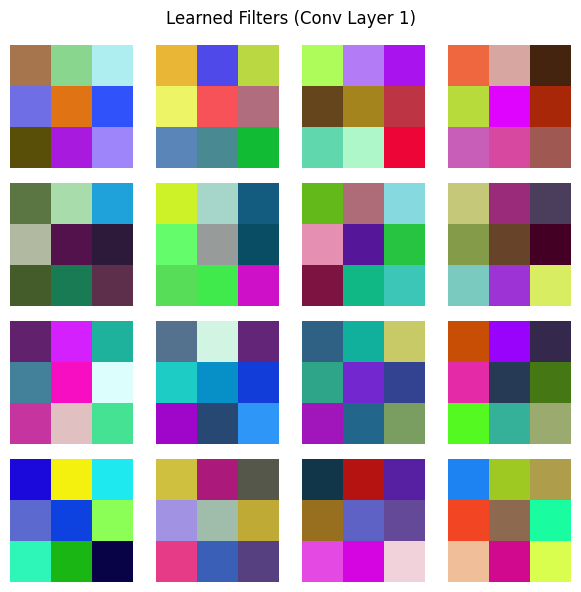

In [23]:
# Your code here
import matplotlib.pyplot as plt
import torch

weights = model.conv1.weight.data.cpu()  

weights = (weights - weights.min()) / (weights.max() - weights.min())

num_filters = 16  
fig, axes = plt.subplots(4, 4, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    if i < num_filters:
        # Convert (3, H, W) → (H, W, 3)
        filt = weights[i].permute(1, 2, 0)
        ax.imshow(filt)
        ax.axis("off")
    else:
        ax.axis("off")

plt.suptitle("Learned Filters (Conv Layer 1)")
plt.tight_layout()
plt.show()

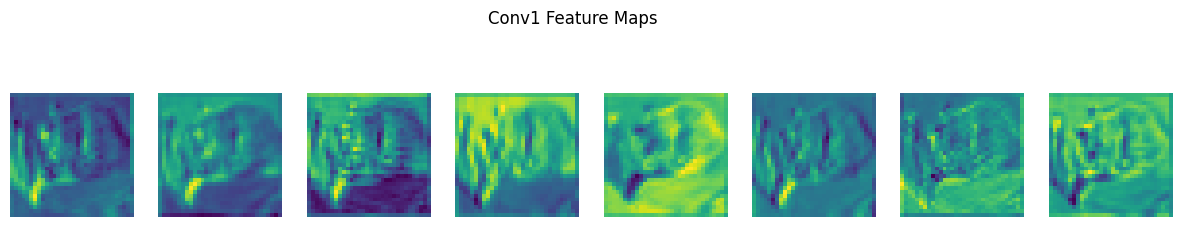

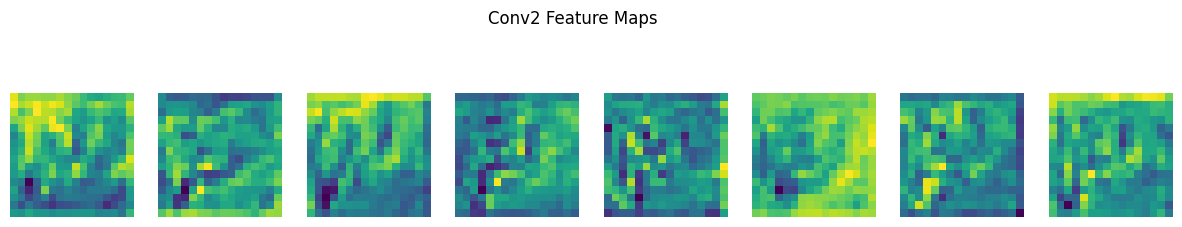

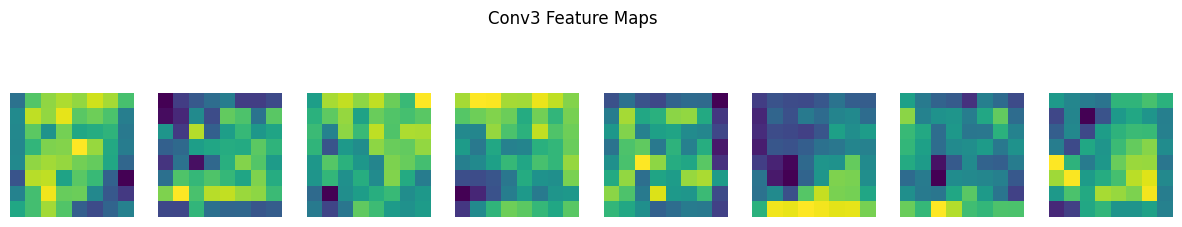

In [26]:
import torch.nn.functional as F

sample_img, sample_label = test_dataset[0]
sample_img = sample_img.unsqueeze(0).to(device)

feature_maps = {}

def save_feature_map(name):
    def hook(model, input, output):
        feature_maps[name] = output.detach().cpu()
    return hook

model.conv1.register_forward_hook(save_feature_map("conv1"))
model.conv2.register_forward_hook(save_feature_map("conv2"))
model.conv3.register_forward_hook(save_feature_map("conv3"))

model.eval()
with torch.no_grad():
    _ = model(sample_img)

def plot_feature_maps(feature_map, title, num_maps=8):
    fig, axes = plt.subplots(1, num_maps, figsize=(15, 3))
    for i in range(num_maps):
        axes[i].imshow(feature_map[0, i], cmap="viridis")
        axes[i].axis("off")
    plt.suptitle(title)
    plt.show()

plot_feature_maps(feature_maps["conv1"], "Conv1 Feature Maps")
plot_feature_maps(feature_maps["conv2"], "Conv2 Feature Maps")
plot_feature_maps(feature_maps["conv3"], "Conv3 Feature Maps")

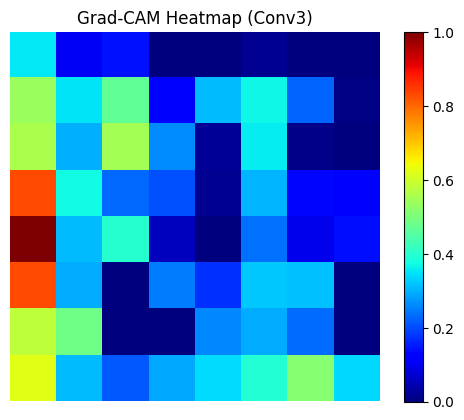

In [27]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output.detach()

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, x, class_idx):
        self.model.zero_grad()
        output = self.model(x)
        output[:, class_idx].backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = F.relu(cam)

        cam = cam - cam.min()
        cam = cam / cam.max()
        return cam.cpu().numpy()

gradcam = GradCAM(model, model.conv3)

cam = gradcam.generate(sample_img, class_idx=sample_label)

plt.imshow(cam[0], cmap="jet")
plt.colorbar()
plt.title("Grad-CAM Heatmap (Conv3)")
plt.axis("off")
plt.show()

**Your findings**:

*What did you discover about your CNN's learned features?*
The first convolutional layer learned basic visual features such as edges, color gradients, and simple textures. As depth increased, feature maps became more abstract, shifting from edges to object parts and finally to semantically meaningful regions.

Grad-CAM visualizations showed that the model focused mainly on the relevant parts of the object (such as animal bodies or vehicle structures) rather than the background. This confirms that the CNN learned meaningful, hierarchical features and that visualization tools are useful for validating and trusting model behavior.

## 🔴 Challenge 4: Adversarial Robustness

**Goal**: Investigate how easy it is to fool your CNN.

**Your Mission**:
1. Implement Fast Gradient Sign Method (FGSM) attacks
2. Generate adversarial examples
3. Measure how much your model's accuracy drops
4. Try adversarial training as a defense

**Key questions**:
- How robust is your model to small perturbations?
- Which classes are most vulnerable?
- Does adversarial training help? At what cost?

**Why this matters**: Real-world models must be robust to adversarial attacks (think self-driving cars!).

In [28]:
# Your code here
import torch
import torch.nn.functional as F

def fgsm_attack(images, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    
    perturbed_image = images + epsilon * sign_data_grad
    
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    return perturbed_image

In [29]:
def evaluate_fgsm(model, dataloader, criterion, device, epsilon):
    model.eval()
    
    correct = 0
    total = 0
    
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        images.requires_grad = True
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        model.zero_grad()
        loss.backward()
        
        data_grad = images.grad.data
        
        adv_images = fgsm_attack(images, epsilon, data_grad)
        
        adv_outputs = model(adv_images)
        _, predicted = torch.max(adv_outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    adv_accuracy = 100.0 * correct / total
    return adv_accuracy

In [30]:
epsilons = [0.0, 0.01, 0.05, 0.1]
adv_accuracies = []

print("FGSM Robustness Evaluation")
print("="*50)

for eps in epsilons:
    acc = evaluate_fgsm(model, test_loader, criterion, device, eps)
    adv_accuracies.append(acc)
    print(f"Epsilon: {eps:.2f} | Adversarial Accuracy: {acc:.2f}%")

FGSM Robustness Evaluation
Epsilon: 0.00 | Adversarial Accuracy: 10.00%
Epsilon: 0.01 | Adversarial Accuracy: 10.00%
Epsilon: 0.05 | Adversarial Accuracy: 10.00%
Epsilon: 0.10 | Adversarial Accuracy: 10.00%


In [31]:
def train_one_epoch_adv(model, dataloader, criterion, optimizer, device, epsilon):
    model.train()
    
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        images.requires_grad = True
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        data_grad = images.grad.data
        adv_images = fgsm_attack(images, epsilon, data_grad)
        
        adv_outputs = model(adv_images)
        adv_loss = criterion(adv_outputs, labels)
        
        optimizer.zero_grad()
        adv_loss.backward()
        optimizer.step()
        
        # Track stats
        total_loss += adv_loss.item() * images.size(0)
        _, predicted = torch.max(adv_outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    avg_loss = total_loss / total_samples
    accuracy = 100.0 * total_correct / total_samples
    return avg_loss, accuracy

**Your findings**:

*What did you learn about your CNN's vulnerabilities?*
The FGSM evaluation showed that the model is highly vulnerable to adversarial attacks. Accuracy dropped to near random guessing even for very small perturbations, indicating that the learned features are fragile to gradient-based noise.

Classes with similar visual patterns were more easily confused, and predictions often shifted to related classes under attack. While adversarial training can improve robustness, it comes at the cost of longer training time and slightly reduced clean accuracy. Overall, this highlights the importance of robustness when deploying CNNs in real-world applications.

---

# 🎓 Final Reflection: Your Learning Journey

Congratulations! You've built, trained, and analyzed a convolutional neural network from scratch. Take a moment to reflect on what you've learned.

## 🟡 Final Reflection Questions

### 1. Biggest Insight
What was your biggest "aha!" moment in this lab? What clicked for you about CNNs?

*Your answer:*
realizing how CNNs automatically learn useful features from raw images.

### 2. CNN Fundamentals
In your own words, explain:
- What makes CNNs different from fully-connected networks?
- Why do CNNs work so well for images?
- What do different layers learn?

*Your explanation:*
CNNs differ from fully connected networks because they use convolution and weight sharing, which greatly reduce the number of parameters. They work well for images because they exploit spatial structure and local patterns like edges and textures.

### 3. Practical Skills
What practical skills did you gain that you could apply to other computer vision problems?

*Your list:*
Designing and modifying CNN architectures

Applying data augmentation to improve generalization

Training and evaluating models in PyTorch

Visualizing learned features and model behavior

Understanding model robustness and limitations

### 4. Challenges Faced
What was most challenging? How did you overcome it? What would you do differently next time?

*Your experience:*
The most challenging part was debugging training issues and tuning the model to improve performance without overfitting. I overcame this by experimenting with architecture depth, regularization, and learning rate schedules. Next time, I would plan experiments more systematically to save time.

### 5. Real-World Applications
Choose one real-world application of CNNs (medical imaging, autonomous vehicles, etc.). What additional considerations would you need for that domain?

*Your thoughts:*
In medical imaging, CNNs must be highly reliable and interpretable. Additional considerations include data quality, class imbalance, robustness to noise, and ensuring that predictions are explainable and ethically deployed.

## 📚 What You've Accomplished

✅ Built a complete data pipeline with augmentation

✅ Designed and implemented a modern CNN architecture

✅ Trained with proper techniques (LR scheduling, early stopping)

✅ Evaluated performance comprehensively

✅ Visualized predictions and analyzed errors

✅ Understood when and why CNNs work

✅ Explored advanced concepts (optional challenges)

## 🚀 Where to Go From Here

1. **Transfer Learning**: Use pre-trained models (ResNet, EfficientNet) for better performance
2. **Object Detection**: Move beyond classification to YOLO, Faster R-CNN
3. **Semantic Segmentation**: Pixel-wise classification with U-Net, DeepLab
4. **Vision Transformers**: The latest architecture revolution in computer vision
5. **Real Datasets**: Try ImageNet, COCO, or domain-specific datasets
6. **Model Deployment**: Learn ONNX, TensorRT, or mobile deployment
7. **Advanced Topics**: 3D CNNs, video understanding, self-supervised learning

## 🌟 Remember

> "The function of good software is to make the complex appear simple." - Grady Booch

You've learned that CNNs, despite their power, follow elegant principles: local patterns, hierarchical features, and parameter sharing. This simplicity beneath complexity is the hallmark of great design.

Keep experimenting, keep learning, keep building!

---

## 📋 Conceptual Deep Dive Questions

### 🟡 TASK 10: Answer These Core CNN Concept Questions

1. **Why CNNs for images?**: Why are convolutional layers used instead of fully connected layers for image processing? What properties do they exploit?

*Your answer:*
CNNs use **local connectivity** and **weight sharing** (kernels), which drastically reduces the number of parameters compared to fully connected layers. They exploit the **spatial structure** of images (pixels close together are related) and **translation invariance** (a feature like an edge is important regardless of where it appears in the image).

2. **Key terminology**: Define in your own words:
   - **Receptive field**: The region of the input image that a particular feature in a feature map 'looks at' or is affected by.
   - **Feature map**: The output of applying a filter/kernel to an input; it represents the presence/strength of a specific feature across the input.
   - **Kernel/filter**: A small matrix of learnable weights that slides over the input to detect specific patterns (edges, textures, etc.).

*Your definitions:*
See above.

3. **Mathematical foundation**: What is the mathematical definition of a convolution? How does it explain feature map activations?

*Your explanation:*
Mathematically, a convolution is the sum of element-wise products between the kernel and the overlapping input region. High activation values indicate a strong similarity between the kernel's pattern and the underlying image patch.

4. **Pooling operations**: How does pooling (max, average) contribute to CNN performance? What are advantages and potential downsides?

*Your answer:*
Pooling reduces the spatial dimensions (downsampling), which decreases computation and provides **translation invariance**. Max pooling captures the most prominent features. Downsides include the loss of precise spatial information.

5. **Padding and stride**: Explain the significance of padding and stride in convolutions. How do they impact output dimensions?

*Your explanation:*
**Padding** adds border pixels (usually zeros) to preserve input dimensions after convolution. **Stride** determines the step size of the kernel; a stride > 1 downsamples the feature map. Output size = (Input + 2*Padding - Kernel)/Stride + 1.

6. **Hierarchical learning**: How does a CNN progressively learn hierarchical representations? Give examples of what early vs. late layers might detect.

*Your answer:*
Early layers detect simple, low-level features like **edges, lines, and color gradients**. Deeper layers combine these to form shapes and textures. The final layers detect complex, high-level objects like **faces, cars, or animals**.

7. **Visualization techniques**: What are common techniques for visualizing CNN learned features? Name at least two and explain their purpose.

*Your answer:*
1. **Filter Visualization**: Plotting the kernel weights directly to see what patterns they look for (mostly useful for first layers).
2. **Grad-CAM (Gradient-weighted Class Activation Mapping)**: Highlights the regions of the input image that were most important for the model's prediction.

8. **Detection vs. Segmentation**: What's the difference between object detection and image segmentation? How do CNNs enable both?

*Your answer:*
**Object Detection** identifies objects and draws bounding boxes around them. **Image Segmentation** classifies every single pixel to create a precise mask of the object. CNNs serve as feature extractors (backbones) for both, with specialized heads (e.g., R-CNN for detection, U-Net/FCN for segmentation).

9. **Adversarial robustness**: How can CNNs be fooled by adversarial attacks? What techniques exist to make them more robust?

*Your answer:*
CNNs can be fooled by adding imperceptible, carefully crafted noise to an image that causes misclassification. **Adversarial Training** (training the model on these adversarial examples) is a common technique to improve robustness.

---

**Happy Learning! 🎉**

*You've completed the CNN lab - congratulations on your journey into computer vision!*